**Deep Learning Framework (Implement Your Own Image classifier)**

Instructors: Mohammad Reza Mohebbian bold text

**Problem statement**
We will load a medical MNIST dataset from : https://github.com/MedMNIST/MedMNIST

In [ ]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 8
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [ ]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)
print(train_dataset)

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Dataset PathMNIST (pathmnist)
    Number of datapoints: 89996
    Root location: /root/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulti

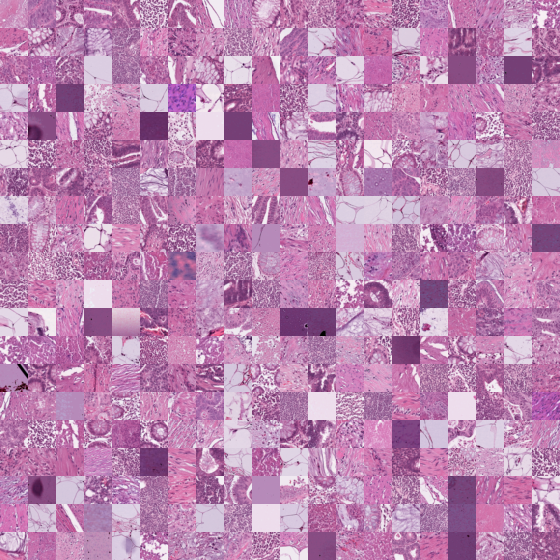

In [ ]:
train_dataset.montage(length=20)

Now we define network, optimizer and loss

In [ ]:
class MedMNISTModel(nn.Module):

    def __init__(self):
        super(MedMNISTModel, self).__init__()
        self.conv_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classification_model = nn.Sequential(
            nn.Linear(in_features=32, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=9),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=0.001)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.conv_model(x)

        # Flattening
        x = torch.flatten(x, start_dim=1)

        x = self.classification_model(x)
        output = F.log_softmax(x, dim=1)
        return x

model = MedMNISTModel()
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
model.to(device)

cuda:0


MedMNISTModel(
  (conv_model): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=9, bias=True)
  )
  (criterion): CrossEntropyLoss()
)

Are we running on GPU or CPU? Please active GPU resource in colab!

Main training loop

In [ ]:
EPOCHS = 10

for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        imgs, targets = data[0].to(device), data[1].to(device)
        outputs = model(imgs)
        loss = model.criterion(outputs, targets.squeeze())

        model.optimizer.zero_grad()
        loss.backward()
        model.optimizer.step()
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

[1,  2000] loss: 1.603
[1,  4000] loss: 1.227
[1,  6000] loss: 1.127
[1,  8000] loss: 1.048
[1, 10000] loss: 0.981
[2,  2000] loss: 0.886
[2,  4000] loss: 0.838
[2,  6000] loss: 0.819
[2,  8000] loss: 0.785
[2, 10000] loss: 0.776
[3,  2000] loss: 0.740
[3,  4000] loss: 0.711
[3,  6000] loss: 0.711
[3,  8000] loss: 0.711
[3, 10000] loss: 0.688
[4,  2000] loss: 0.665
[4,  4000] loss: 0.664
[4,  6000] loss: 0.655
[4,  8000] loss: 0.635
[4, 10000] loss: 0.656
[5,  2000] loss: 0.622
[5,  4000] loss: 0.626
[5,  6000] loss: 0.616
[5,  8000] loss: 0.607
[5, 10000] loss: 0.614
[6,  2000] loss: 0.594
[6,  4000] loss: 0.593
[6,  6000] loss: 0.594
[6,  8000] loss: 0.582
[6, 10000] loss: 0.584
[7,  2000] loss: 0.576
[7,  4000] loss: 0.580
[7,  6000] loss: 0.578
[7,  8000] loss: 0.571
[7, 10000] loss: 0.564
[8,  2000] loss: 0.557
[8,  4000] loss: 0.547
[8,  6000] loss: 0.554
[8,  8000] loss: 0.565
[8, 10000] loss: 0.554
[9,  2000] loss: 0.549
[9,  4000] loss: 0.538
[9,  6000] loss: 0.552
[9,  8000] 

Evaluation

In [ ]:
predicted = []
targets = []
with torch.no_grad():
  for i, data in enumerate(test_loader):
      img, target = data[0].to(device), data[1].item()
      output = torch.argmax(model(img).cpu(), dim=1).detach().numpy()
      predicted.append(output)
      targets.append(target)

Save model

In [ ]:
torch.save(model.state_dict(), "model.pth")

Calculating metrics

Accuracy of the model is 75.18%


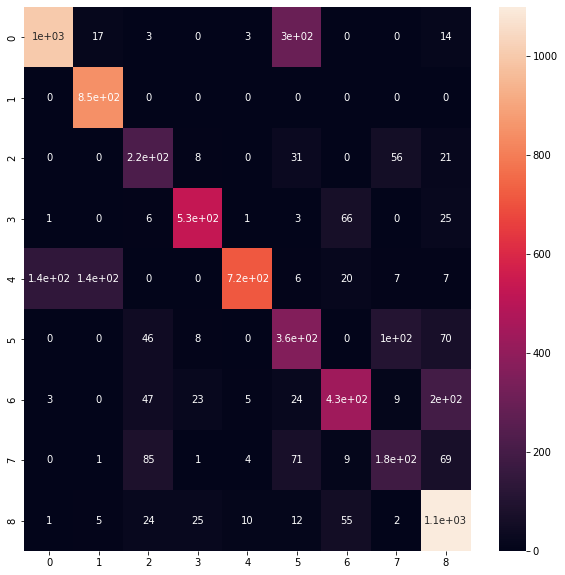

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

accuracy = np.asarray(accuracy_score(targets, predicted)*100)
accuracy = accuracy.round(2)
print("Accuracy of the model is {}%".format(accuracy))
cf_mt = confusion_matrix(targets, predicted)
plt.figure(figsize=(10, 10))
sns.heatmap(cf_mt, annot=True)